**Author**: Justine Debelius<br>
**email**: jdebelius@ucsd.edu<br>
**enviroment**: agp_2017<br>
**Date**: 16 May 2017<br>
**Update**: 3 November 2017

This notebook will build a linear regression comparing the alpha diversity of participants in the American Gut to covariates fo interest.

We're going to focus on a subset of the participants. Namely, we're going to look at individuals living in the US and UK with a BMI of less than 40.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import scipy
import skbio
import seaborn as sn
import statsmodels.api as sms
import statsmodels.formula.api as smf

%matplotlib inline

We'll start by loading the study metadata and converting the alpha diversity, age, and BMI to floats.

In [3]:
map_ = pd.read_csv('./ag_map_with_alpha.txt', sep='\t', dtype=str)
map_.set_index('#SampleID', inplace=True)

map_.replace('Unspecified', np.nan, inplace=True)

In [4]:
map_['faiths_pd_1250'] = map_['faiths_pd_1250'].astype(float)

In [5]:
map_['age_corrected'] = map_['age_corrected'].astype(float)
map_.loc[map_['age_corrected'] > 105, 'age_corrected'] = np.nan

map_['bmi_corrected'] = map_['bmi_corrected'].astype(float)

Next, we'll load the bloom percentage file, and add that to the mapping file.

In [6]:
bloom = pd.read_csv('./ag-bloom-fractions-125nt.txt', sep='\t', dtype=str)
bloom.set_index('#SampleID', inplace=True)

In [7]:
map_['bloom_fraction'] = bloom['bloom_fraction'].astype(float)

We're going to only look at samples from the US, UK, Australia and Canada, since these represent about 92% of the samples in the data set. We'll also limit the data based on BMI, limit the data set to participants who have provided their sex and male and female. 

In [11]:
def filter_map(x):
    country = x['country'] in {'USA', 'United Kingdom', 'Canada', 'Australia'}
    bmi = (x['bmi_corrected'] < 40) and (pd.isnull(x['bmi_corrected']) == False)
    sex = x['sex'] in {'male', 'female'}
    poo = x['bowel_movement_quality'] not in {"I don't know, I do not have a point of reference"}
    race = x['race'] in {'Caucasian', 'Asian or Pacific Islander', 'Other'}
    pox = x['chickenpox'] in {'No', 'Yes'}
    
    return country & bmi & sex & poo & race & pox

In [12]:
study_columns = [
    'center_project_name',
    'age_corrected', 
    'age_cat',
    'alcohol_frequency', 
    'antibiotic_history',
    'bmi_corrected', 
    'bowel_movement_quality', 
    'ibd', 
    'ibs',
    'country', 
    'race', 
    'types_of_plants',
    'sex', 
    'sleep_duration', 
    'faiths_pd_1250',
    'chickenpox',
    'bloom_fraction'
    ]

In [15]:
fmap_ = map_.loc[map_.apply(filter_map, axis=1)]
dmap_ = fmap_[study_columns].dropna()

We'll also filter the map to remove any center project name category with less than 100 samples, so that if we chose to include it in the regression, we have enough groups that it won't lead to weird behavior.

In [18]:
cpn_counts = dmap_['center_project_name'].value_counts()
cpn_filter = set(cpn_counts.index[cpn_counts > 100])

In [19]:
smap_ = dmap_.loc[dmap_['center_project_name'].apply(lambda x: x in cpn_filter)]

We're going to do some additional clean up, to make life easier? 

So, we'll combine the self diagnosed or alternative medicate practioner diagnosis into a `non medical diagnosis` category. This allows us to keep the individuals, but combines the groups.

We'll rename the alcohol frequency, antibiotic history, bowel movement quality, and to make them prettier in the regression.<br>
We'll also combine people who took antibiotics in the last week and the last month, since the last week is also part of the last month.<br>
We'll also combine the sleep durations of less than 6 hours (Less than 5 and 5 - 6).



We're going to code the data using numeric codeing, since this will be easier for patsy to handle.
We'll also do some work to build combinations.

We're going to combine the antibiotics in the last week and in the last month. <br>
For both IBD and IBS, we will combine people who were idagnosed by an alternative medicine practioner or self diagnosed individuals into a different category.

In [20]:
numeric_coding = {'alcohol_frequency': {'Never': 0,
                                        'Rarely (a few times/month)': 1,
                                        'Occasionally (1-2 times/week)': 2,
                                        'Regularly (3-5 times/week)': 3,
                                        'Daily': 4,
                                        },
                  'antibiotic_history': {'I have not taken antibiotics in the past year.': 0,
                                         'Year': 1,
                                         '6 months': 2,
                                         'Month': 3,
                                         'Week': 3,
                                         },
                  'bowel_movement_quality': {'I tend to have normal formed stool': 0,
                                             'I tend to have diarrhea (watery stool)': 1,
                                             'I tend to be constipated (have difficulty passing stool)': 2,
                                             },
                  'chickenpox': {'No': 0,
                                 'Yes': 1,
                                },
                  'country': {'USA': 0,
                              'United Kingdom': 1,
                              'Canada': 2,
                              'Australia': 3,
                              },
                  'ibd': {'I do not have this condition': 0,
                          'Diagnosed by a medical professional (doctor, physician assistant)': 1,
                          'Self-diagnosed': 2,
                          'Diagnosed by an alternative medicine practitioner': 2,
                          },
                  'ibs': {'I do not have this condition': 0,
                          'Diagnosed by a medical professional (doctor, physician assistant)': 1,
                          'Self-diagnosed': 2,
                          'Diagnosed by an alternative medicine practitioner': 2,
                          },
                  'race': {"Caucasian": 0,
                           'Asian or Pacific Islander': 1,
                           'Other': 2,
                           },
                  'sex': {'female': 0, 
                          'male': 1},
                  'sleep_duration': {'Less than 5 hours': 0,
                                     '5-6 hours': 0,
                                     '6-7 hours': 1,
                                     '7-8 hours': 2,
                                     '8 or more hours': 3,
                                     },
                  'types_of_plants': {'Less than 5': 0,
                                      '6 to 10': 1,
                                      '11 to 20': 2,
                                      '21 to 30': 3,
                                      'More than 30': 4,
                                      },
                  }

In [21]:
smap_numeric = smap_.replace(numeric_coding)

In [22]:
smap_numeric['ln_age'] = np.log(smap_numeric['age_corrected'] + 1)

In [23]:
smap_numeric.to_csv('./coded_regression_map_5k.txt', sep='\t', index_label='#SampleID')

In [24]:
!pwd

/Users/jwdebelius/Repositories/american-gut-analyses/ipynb


Next, we'll build a regression including the covariate we're potentially interested in.

Next, we'll build a function that will let us preform a step-wise selection based on a decrease in the AIC, an increase in the adjusted $R^{2}$ and not blowing up the condition number.

In [25]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     43.18
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           6.26e-11
Time:                        13:59:21   Log-Likelihood:                -5719.1
No. Observations:                2149   AIC:                         1.144e+04
Df Residuals:                    2147   BIC:                         1.145e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         14.0161      0.097    144.

In [26]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country)', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     47.76
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           1.61e-38
Time:                        13:59:22   Log-Likelihood:                -5648.8
No. Observations:                2149   AIC:                         1.131e+04
Df Residuals:                    2144   BIC:                         1.134e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          13.2536      0.114    1

In [27]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd)', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     39.67
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           5.70e-46
Time:                        13:59:22   Log-Likelihood:                -5627.3
No. Observations:                2149   AIC:                         1.127e+04
Df Residuals:                    2142   BIC:                         1.131e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          13.3348      0.113    1

In [28]:
fit1 = smf.ols('faiths_pd_1250 ~ C(country) + C(ibd) + C(ibs)', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     31.27
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           1.68e-41
Time:                        13:59:22   Log-Likelihood:                -5635.9
No. Observations:                2149   AIC:                         1.129e+04
Df Residuals:                    2141   BIC:                         1.133e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          13.1012      0.103    1

In [29]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history)', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     30.44
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           2.94e-60
Time:                        13:59:22   Log-Likelihood:                -5584.1
No. Observations:                2149   AIC:                         1.119e+04
Df Residuals:                    2137   BIC:                         1.126e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept           

In [30]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) '
               '+ C(antibiotic_history) + C(race)', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     32.86
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           2.38e-75
Time:                        13:59:22   Log-Likelihood:                -5544.5
No. Observations:                2149   AIC:                         1.112e+04
Df Residuals:                    2135   BIC:                         1.120e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept           

In [31]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history)'
               ' + age_corrected', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     36.69
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           2.11e-78
Time:                        13:59:23   Log-Likelihood:                -5539.1
No. Observations:                2149   AIC:                         1.110e+04
Df Residuals:                    2136   BIC:                         1.118e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept           

/Users/jwdebelius/miniconda3/envs/agp_2017/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


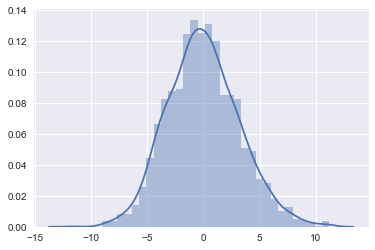

In [32]:
sn.distplot(fit1.resid)

In [33]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history)'
               ' + ln_age', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     36.98
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           5.17e-79
Time:                        13:59:23   Log-Likelihood:                -5537.7
No. Observations:                2149   AIC:                         1.110e+04
Df Residuals:                    2136   BIC:                         1.118e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept           

/Users/jwdebelius/miniconda3/envs/agp_2017/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


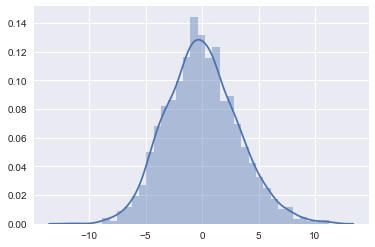

In [34]:
sn.distplot(fit1.resid)

In [35]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history)'
               '+ ln_age + C(sex)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     35.46
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           2.82e-81
Time:                        13:59:23   Log-Likelihood:                -5530.4
No. Observations:                2149   AIC:                         1.109e+04
Df Residuals:                    2135   BIC:                         1.117e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept           

In [36]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history)'
               ' + ln_age*C(sex)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     33.65
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           2.73e-82
Time:                        13:59:24   Log-Likelihood:                -5526.1
No. Observations:                2149   AIC:                         1.108e+04
Df Residuals:                    2134   BIC:                         1.117e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept           

In [37]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + antibiotic_history + ln_age*C(sex)'
               '+ C(types_of_plants)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     31.51
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           1.70e-86
Time:                        13:59:24   Log-Likelihood:                -5512.4
No. Observations:                2149   AIC:                         1.106e+04
Df Residuals:                    2132   BIC:                         1.116e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                 

In [38]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + antibiotic_history '
               ' + ln_age*C(sex) + C(types_of_plants) + C(race)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     31.59
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           6.10e-96
Time:                        13:59:24   Log-Likelihood:                -5486.2
No. Observations:                2149   AIC:                         1.101e+04
Df Residuals:                    2130   BIC:                         1.112e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                 

In [39]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history) + '
               'ln_age*C(sex) + C(types_of_plants) + C(race) + C(sleep_duration)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     24.93
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           2.91e-93
Time:                        13:59:25   Log-Likelihood:                -5483.9
No. Observations:                2149   AIC:                         1.102e+04
Df Residuals:                    2125   BIC:                         1.115e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept           

In [40]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history) + '
               'ln_age*C(sex) + C(types_of_plants) + C(race) + C(sleep_duration) + C(bowel_movement_quality)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     24.07
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           1.32e-96
Time:                        13:59:25   Log-Likelihood:                -5472.3
No. Observations:                2149   AIC:                         1.100e+04
Df Residuals:                    2123   BIC:                         1.114e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept   

In [41]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history) + '
               'ln_age*C(sex) + C(types_of_plants) + C(race) + C(sleep_duration) + C(bowel_movement_quality)'
               '+ C(chickenpox)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     23.25
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           2.14e-96
Time:                        13:59:25   Log-Likelihood:                -5471.2
No. Observations:                2149   AIC:                         1.100e+04
Df Residuals:                    2122   BIC:                         1.115e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept   

/Users/jwdebelius/miniconda3/envs/agp_2017/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


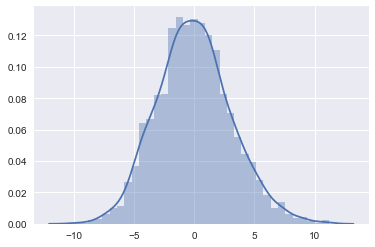

In [42]:
sn.distplot(fit1.resid)

In [43]:
summary = fit1.summary()

In [44]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history) + '
               'ln_age*C(sex) + C(types_of_plants) + C(race) + C(sleep_duration) + C(bowel_movement_quality)'
               '+ C(chickenpox) + bmi_corrected', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     24.02
Date:                Sun, 05 Nov 2017   Prob (F-statistic):          7.39e-103
Time:                        13:59:27   Log-Likelihood:                -5453.8
No. Observations:                2149   AIC:                         1.096e+04
Df Residuals:                    2121   BIC:                         1.112e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept   

In [45]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history) + '
               'ln_age*C(sex) + C(types_of_plants) + C(race) + C(sleep_duration) + C(bowel_movement_quality)'
               '+ C(chickenpox)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     23.25
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           2.14e-96
Time:                        13:59:28   Log-Likelihood:                -5471.2
No. Observations:                2149   AIC:                         1.100e+04
Df Residuals:                    2122   BIC:                         1.115e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept   

In [46]:
fit1.summary().as_csv()

'                      OLS Regression Results                      \nDep. Variable:   ,faiths_pd_1250  ,  R-squared:         ,   0.222 \nModel:           ,OLS             ,  Adj. R-squared:    ,   0.212 \nMethod:          ,Least Squares   ,  F-statistic:       ,   23.25 \nDate:            ,Sun, 05 Nov 2017,  Prob (F-statistic):,2.14e-96 \nTime:            ,13:59:28        ,  Log-Likelihood:    , -5471.2 \nNo. Observations:,  2149          ,  AIC:               ,1.100e+04\nDf Residuals:    ,  2122          ,  BIC:               ,1.115e+04\nDf Model:        ,    26          ,                     ,         \nCovariance Type: ,nonrobust       ,                     ,         \n                              ,   coef   , std err ,    t    ,P>|t| , [95.0% Conf. Int.]\nIntercept                     ,    8.7930,    1.053,    8.352, 0.000,    6.728    10.858\nC(country)[T.1]               ,    1.4377,    0.144,    9.976, 0.000,    1.155     1.720\nC(country)[T.2]               ,    0.2408,    0.5

In [47]:
fit1.pvalues.values

array([  1.19490392e-16,   6.15354305e-23,   6.82044727e-01,
         1.04180482e-01,   2.19640985e-06,   3.51077811e-01,
         1.79950328e-03,   1.23580346e-02,   3.45186507e-03,
         3.65084610e-09,   3.54204791e-07,   3.68085201e-03,
         9.94817249e-01,   3.29172015e-01,   2.51779902e-02,
         4.47332000e-03,   1.95284091e-09,   9.55824472e-05,
         9.15243296e-02,   5.55220708e-02,   4.60502495e-02,
         1.91345572e-05,   2.32568350e-01,   1.27271323e-01,
         1.63413375e-16,   6.32670656e-07,   7.21178475e-03])